1) Summary of dataset

- Full descriptive summary of the dataset
- Number of observations
- Summary statistics (to 2 decimal places)
- Number of variables
- Name and type of variables
- What these variables mean
- Any issues with the data
- Any issues related to things we can't directly see
- How the data was collected
- Etc

Should be in tables and bullet point lists, esps for summarizing variables.
Should summarize all variables, not just the ones I need for my question.

| Variable Name | Type | Meaning | Summary Stat |
| ------------- | ---- | ------- | ------------ |
| experience    |  chr |Category of familiarity with Minecraft | See summary below |
| subscribe     | lgl  | True if player is subscribed to mailing list, False if not | 144 True/52 False (73.47% True) |
| hashedEmail   | chr  | Player email, hashed for privacy | 0 repeated emails|
| played_hours  | dbl  | Hours played  | Mean: 5.85|
| name          | chr  | Identifying name of player | 0 repeated names|
| gender        | chr  | Gender disclosed by player (including choice to opt-out) | See summary below |
| Age           | dbl  | Age of player | Mean: 21.14 |

Players: 196 observations. 7 variables.

Sessions: 1535 observations. 5 variables.

Issues:
- Experience and gender should be converted to factors
- Age has some NAs


| Variable Name       | Type | Meaning | Summary Stat |
| ------------------- | ---- | ------- | ------------ |
| hashedEmail         | chr  | Player email, hashed for privacy | Total number of unique hashed emails: 125 <br> Mean repeat session count: 12.28 |
| start_time          | chr  | Start of session in day/month/year and 24 hr format | (All calculated by converting to datetime)<br>Min : 2024-04-06 09:27:00 <br> Max: 2024-09-26 06:09:00 |
| end_time            | chr  | End of session in same format as start_time | (All calculated by converting to datetime)<br>Min: 2024-04-06 09:31:00 <br> Max: 2024-09-26 07:39:00 <br> Mean duration between start_time and end_time: 50.86 mins|
| original_start_time | dbl  | Lower precision session start time, expressed in milliseconds from Unix Epoch | Mean duration combined with original_end_time: 48.49 minutes |
| original_end_time   | dbl  | Lower precision session end time, in same format as original_start_time |  |

Issues:
- start_time and end_time need to be converted into date types, not characters
- The meaning of original_start_time and original_end_time are unclear. They seem to be in milliseconds from Unix Epoch time, since if you treat them as such they are close to the matching values in start_time and end_time. But the times don't match exactly. I also noticed that the original_start_time and original_end_time are often the same, so my current guess is that some precision was lost on these values and that's why they're not quite right.
- We'll need to pick which source of start/end times to use for analysis. I plan to use start_time and end_time since they seem to be different from each other more often than the Unix Epoch versions, which would make more sense if a play session was recorded.
- end_time and original_end_time have some NAs

Notes on the dataset, based on the project website:
-  Current announcement says the server restarts daily at 2:30 AM PST
-  Participation rules say that if a player is away from keyboard for more than 5 min they get kicked from the server
-  Rules also state that there is a PLAITime mechanic. You start with 30 minutes. If you aren't talking to players, it is ticking down. You earn time by inviting friends and talking in game. You can't begin a play session without 30 minutes of PLAITime. So basically if you play solo, you get 30 min then you're kicked.
-  A player who joins but never does any movement is considered a no-show.
-  FAQ says that as of May 2025, over 10000 people have played over 10000 hours.
-  FAQ says generally 1-20 people active at a time.
-  FAQ says benefit offered to players was the chance to play on the server for free, and occassionally sweepstakes to win an Amazon gift card.
-  Players are encouraged to play with people they don't already know, but can also invite friends.
-  FAQ notes that email or phone number are collected in order to send links to access the server, and to be able to identify and delete data is required.
-  FAQ notes that players 13 and under must have a parent or guardian consent to participate. Parents can revoke consent and then data is deleted.
- FAQ notes that they collect gameplay, speech, and key presses.
- FAQ notes that players can request specific session IDs are removed if they want to remove any data.
- The first blog post on their current website is from Sept 1st, 2024. On Sept 27th 2024 they say they've passed research ethics certification.
- From the UBC lab page for PLAI it has a post about launching plaicraft.ai on Sept 27th 2023
- Their released paper talks about using extensive media outreach - TikTok, Youtube, collabs with famous Minecraft YouTubers, posters. Also one semester of giving extra credit to undergrads who would play.

In [6]:
library(tidyverse)
library(repr)
options(repr.matrix.max.rows = 6)

In [7]:
players = read_csv("players.csv")
sessions = read_csv("sessions.csv")

players

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Amateur,FALSE,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Dylan,Prefer not to say,57
Amateur,FALSE,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,2.3,Harlow,Male,17
Pro,TRUE,d9473710057f7d42f36570f0be83817a4eea614029ff90cf50d8889cdd729d11,0.2,Ahmed,Other,NA


In [54]:
# Writing a basic function to report on summary stats for a numerical variable, to avoid needing to set up a bunch of extra variables
# (I know we haven't been taught functions in this course, but I hope it's alright, in the way that TA code often also has extra functionality!)

report_numerical_stats = function(tibble, column) {
    na_count = tibble |>
        filter(is.na({{column}} == TRUE)) |>
        summarize(n = n()) |>
        pull(n)

    print("NA count: ")
    print(na_count)
    
    summary = tibble |>
        summarize(mean = mean({{column}}, na.rm = TRUE), min = min({{column}}, na.rm = TRUE), max = max({{column}}, na.rm = TRUE)) 
    return(summary)
}

report_distribution_as_factor = function(tibble, column) {
    na_count = tibble |>
        filter(is.na({{column}} == TRUE)) |>
        summarize(n = n()) |>
        pull(n)

    print("NA count: ")
    print(na_count)

    distribution = tibble |>
        group_by(as_factor({{column}})) |>
        summarize(n = n())

    return(distribution)
}

print("Players: Played Hours")
report_numerical_stats(players, played_hours)
print("Players: Age")
report_numerical_stats(players, Age)
print("Players: Gender")
report_distribution_as_factor(players, gender)
print("Players: Experience")
report_distribution_as_factor(players, experience)
print("Players: subscribe")
report_distribution_as_factor(players, subscribe)
print("Players: name")
report_distribution_as_factor(players, name)
print("players: hashed email")
report_distribution_as_factor(players, hashedEmail)

print("sessions: original start")
report_numerical_stats(sessions, original_start_time)
print("sessions: original end")
report_numerical_stats(sessions, original_end_time)

[1] "Players: Played Hours"
[1] "NA count: "
[1] 0


mean,min,max
<dbl>,<dbl>,<dbl>
5.845918,0,223.1


[1] "Players: Age"
[1] "NA count: "
[1] 2


mean,min,max
<dbl>,<dbl>,<dbl>
21.13918,9,58


[1] "Players: Gender"
[1] "NA count: "
[1] 0


as_factor(gender),n
<fct>,<int>
Male,124
Female,37
Non-binary,15
⋮,⋮
Agender,2
Two-Spirited,6
Other,1


[1] "Players: Experience"
[1] "NA count: "
[1] 0


as_factor(experience),n
<fct>,<int>
Pro,14
Veteran,48
Amateur,63
Regular,36
Beginner,35


[1] "Players: subscribe"
[1] "NA count: "
[1] 0


as_factor(subscribe),n
<fct>,<int>
FALSE,52
TRUE,144


[1] "Players: name"
[1] "NA count: "
[1] 0


as_factor(name),n
<fct>,<int>
Morgan,1
Christian,1
Blake,1
⋮,⋮
Dylan,1
Harlow,1
Ahmed,1


[1] "players: hashed email"
[1] "NA count: "
[1] 0


as_factor(hashedEmail),n
<fct>,<int>
f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,1
f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,1
b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,1
⋮,⋮
d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,1
f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,1
d9473710057f7d42f36570f0be83817a4eea614029ff90cf50d8889cdd729d11,1


[1] "sessions: original start"
[1] "NA count: "
[1] 0


mean,min,max
<dbl>,<dbl>,<dbl>
1.719201e+12,1.7124e+12,1.72733e+12


[1] "sessions: original end"
[1] "NA count: "
[1] 2


mean,min,max
<dbl>,<dbl>,<dbl>
1.719196e+12,1.7124e+12,1.72734e+12


In [34]:
# investigate the format of the two date columns
exampleMysteryDate = sessions |>
    slice(8) |>
    pull(original_start_time)

exampleKnownDate = sessions |>
    slice(8) |>
    pull(start_time) |>
    as_datetime()

exampleKnownDate
exampleMysteryDate

# See what the mystery date looks like if treated as milliseconds from Epoch Time
convertedDate = as_datetime(exampleMysteryDate/1000)
convertedDate

# do the same but for the end time
exampleMysteryEnd = sessions |>
    slice(8) |>
    pull(original_end_time)

end_time = sessions |>
    slice(8) |>
    pull(end_time)

end_time
exampleMysteryEnd
print(as_datetime(exampleMysteryEnd/1000))

[1] "2021-09-21 00:02:13 UTC"

[1] 1.72688e+12

[1] "2024-09-21 00:53:20 UTC"

[1] "21/09/2024 02:30"

[1] 1.72689e+12

[1] "2024-09-21 03:40:00 UTC"


In [60]:
# group by repeat sessions, aka ones with the same email

repeat_sessions = sessions |>
    group_by(hashedEmail) |>
    summarize(n = n())

repeat_sessions
print(nrow(repeat_sessions))

# average number of sessions a given player played
repeat_session_mean = repeat_sessions |>
    summarize(mean = mean(n)) |>
    pull()

repeat_session_mean

# convert the chr variables into date variables so we can do math with them
# while we're at it, get the duration of time between start and end for each session
converted_times = sessions |>
    mutate(converted_start = dmy_hm(start_time)) |>
    mutate(converted_end = dmy_hm(end_time)) |>
    mutate(duration = converted_end - converted_start)

converted_times

# get the min and max, which tells us over what span of time this chunk of the study took place
max_start_date = converted_times |>
    summarize(max = max(converted_start)) |>
    pull()

print(max_start_date)

min_start_date = converted_times |>
    summarize(min = min(converted_start)) |>
    pull()

print(min_start_date)

max_end_date = converted_times |>
    summarize(max = max(converted_end, na.rm = TRUE)) |>
    pull()

print(max_end_date)

min_end_date = converted_times |>
    summarize(min = min(converted_end, na.rm = TRUE)) |>
    pull()

print(min_end_date)

# get the duration of time between start and end of each session, then calculate the mean
mean_duration = converted_times |>
    summarize(mean = mean(duration, na.rm = TRUE)) |>
    pull()

mean_duration

# for the epoch time, also calculated the duration and mean of the duration, for comparison
mean_epoch_duration = sessions |>
    mutate(epoch_duration = original_end_time - original_start_time) |>
    summarize(mean = mean(epoch_duration, na.rm = TRUE)) |>
    pull()

# convert from milliseconds to minutes
mean_epoch_duration / 1000 / 60

hashedEmail,n
<chr>,<int>
0088b5e134c3f0498a18c7ea6b8d77b4b0ff1636fc93355ccc95b45423367832,2
060aca80f8cfbf1c91553a72f4d5ec8034764b05ab59fe8e1cf0eee9a7b67967,1
0ce7bfa910d47fc91f21a7b3acd8f33bde6db57912ce0290fa0437ce0b97f387,1
⋮,⋮
fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d,310
fe218a05c6c3fc6326f4f151e8cb75a2a9fa29e22b110d4c311fb58fb211f471,1
fef4e1bed8c3f6dcd7bcd39ab21bd402386155b2ff8c8e53683e1d2793bf1ed1,1


[1] 125


[1] 12.28

hashedEmail,start_time,end_time,original_start_time,original_end_time,converted_start,converted_end,duration
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dttm>,<dttm>,<drtn>
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,30/06/2024 18:12,30/06/2024 18:24,1.71977e+12,1.71977e+12,2024-06-30 18:12:00,2024-06-30 18:24:00,12 mins
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,17/06/2024 23:33,17/06/2024 23:46,1.71867e+12,1.71867e+12,2024-06-17 23:33:00,2024-06-17 23:46:00,13 mins
f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc,25/07/2024 17:34,25/07/2024 17:57,1.72193e+12,1.72193e+12,2024-07-25 17:34:00,2024-07-25 17:57:00,23 mins
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d,28/07/2024 15:36,28/07/2024 15:57,1.72218e+12,1.72218e+12,2024-07-28 15:36:00,2024-07-28 15:57:00,21 mins
fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d,25/07/2024 06:15,25/07/2024 06:22,1.72189e+12,1.72189e+12,2024-07-25 06:15:00,2024-07-25 06:22:00,7 mins
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,20/05/2024 02:26,20/05/2024 02:45,1.71617e+12,1.71617e+12,2024-05-20 02:26:00,2024-05-20 02:45:00,19 mins


[1] "2024-09-26 06:09:00 UTC"
[1] "2024-04-06 09:27:00 UTC"
[1] "2024-09-26 07:39:00 UTC"
[1] "2024-04-06 09:31:00 UTC"


Time difference of 50.85845 mins

[1] 48.4888

In [47]:
players = players |>
    mutate(experience = as_factor(experience)) |>
    mutate(gender = as_factor(gender))

exp_counts = players |>
    group_by(experience) |>
    summarize(n = n())

exp_counts

subscribe_counts = players |>
    group_by(subscribe) |>
    summarize(n = n())

subscribe_counts

unique_email_count = players |>
    group_by(hashedEmail) |>
    summarize(n = n()) |>
    filter(n > 1)

unique_email_count

hours_mean = players |>
    summarize(mean = mean(played_hours)) |>
    pull() |>
    round(2)

hours_mean

name_overlaps = players |>
    group_by(name) |>
    summarize(n = n()) |>
    filter(n > 1)

name_overlaps

gender_counts = players |>
    group_by(gender) |>
    summarize(n = n())

gender_counts

age_mean = players |>
    summarize(age_mean = mean(Age, na.rm = TRUE)) |>
    pull() |>
    round(2)

age_mean

experience,n
<fct>,<int>
Pro,14
Veteran,48
Amateur,63
Regular,36
Beginner,35


subscribe,n
<lgl>,<int>
FALSE,52
TRUE,144


hashedEmail,n
<chr>,<int>


[1] 5.85

name,n
<chr>,<int>


gender,n
<fct>,<int>
Male,124
Female,37
Non-binary,15
⋮,⋮
Agender,2
Two-Spirited,6
Other,1


[1] 21.14

2) Question:
The one broad question I plan to address, and then how I've formulated it into a specific question that uses one response vaiable of interest and one or more explanatory variables.
- It should be stated as a question
- Ex, can foo predict bar in dataset?
- Describe how the data will help address the question of interest
- Potentially describe how to wrangle the data to get it into the form where I can apply one of the predictive methods we've learned.

Broad question: We would like to know which "kinds" of players are most likely to contribute a large amount of data so that we can target those players in our recruiting efforts.

Specific: Can the age and experience of a player be used to predict the sum total of hours played across multiple sessions of PLAICraft?

Age, experience, and gender are the demographic pieces of information available to us in the data. Gender isn't one I know how to work with because it's categorical and there isn't a clear way to translate it to numeric. Experience is categorical but it exists on a scale, so we can convert it to a number. What I wish I could include is whether they joined on their own or played with pre-existing friends, but I don't think we could reliably figure that out. We could look for how many other players were online during their session but that is different from the broad question asking about 'kinds' of players.
For 'large amounts of data' we want to sum up all their sessions. From what I understand of their research, I don't think one long session is necessarily any better than a large number of shorter sessions. So a simple sum should be fine.
Actually there's an entry in the players table for total hours, I don't even need to do any of that.
The broad question says "a large amount of data" which will probably mean at some point defining a threshold of sum hours that is considered 'large' and so the question becomes whether or not the predicted sum total hits that threshold or not.

Wrangling will include:
- Convert experience into a numeric scale from 1-5

3. Exploratory Data Analysis and Visualization

- Load the dataset into R
- Do the minimum necessary wrangling to make the data tidy. Nothing extra!
- Compute the mean value for each quantitative variable in players.csv. Report the mean values in a table format.
- Make a few exploratory visualizations of the data to help understand it
- Use viz best practices (labels, titles, units, etc)
- Explain any insights from the plots that are relevant to my question
- No predictive analysis, just exploration before later modelling.

Thoughts on what to explore:
- Histogram of hours played
- Histogram of age
- Bar chart of experience
- Scatterplot of experience and hours played
- Scatterplot of age and hours played

Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`).”


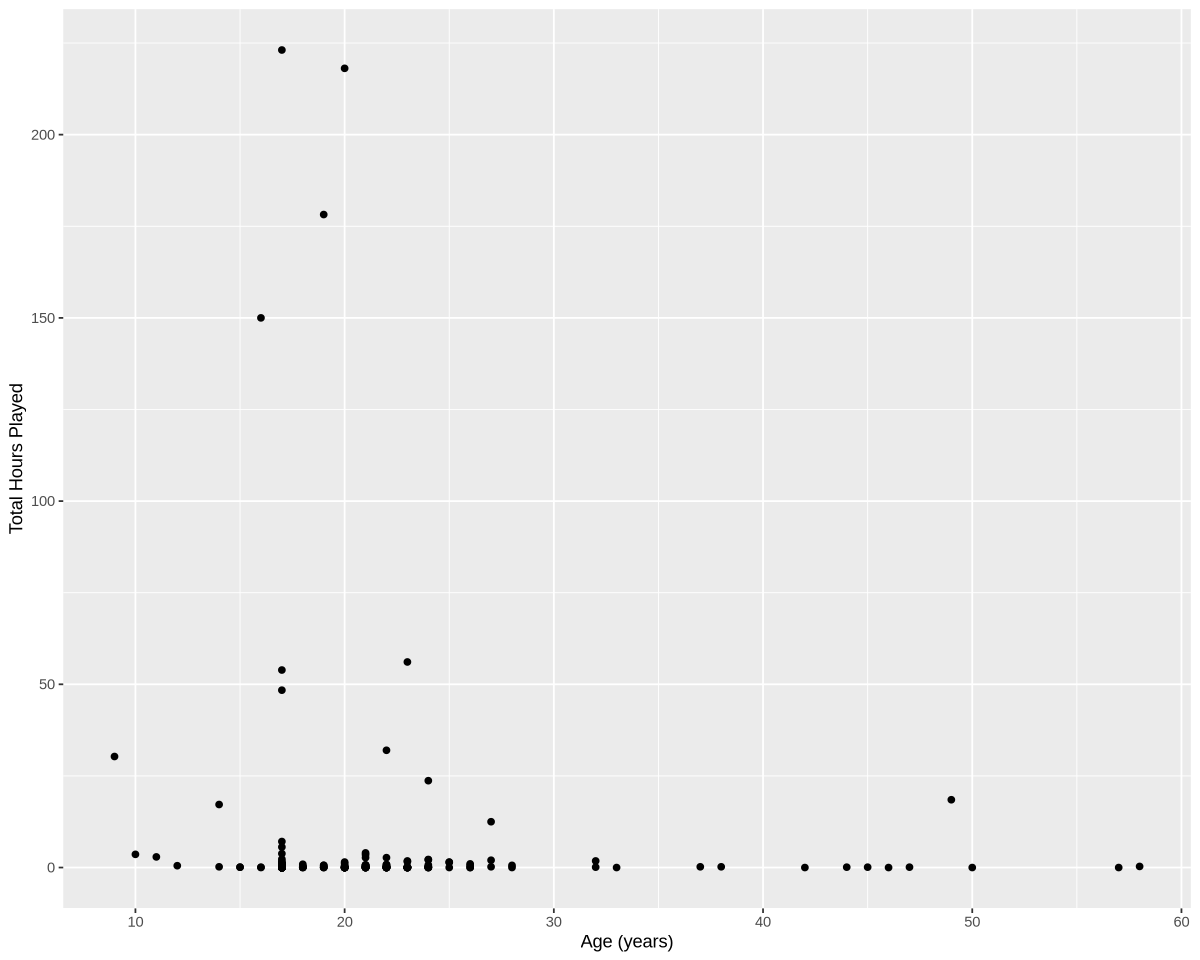

In [45]:
age_time_plot = players |>
    #filter(played_hours > 0) |>
    ggplot(aes(x = Age, y = played_hours)) +
    geom_point() +
    labs(x = "Age (years)", y = "Total Hours Played") ##+
    ##scale_y_log10()

age_time_plot

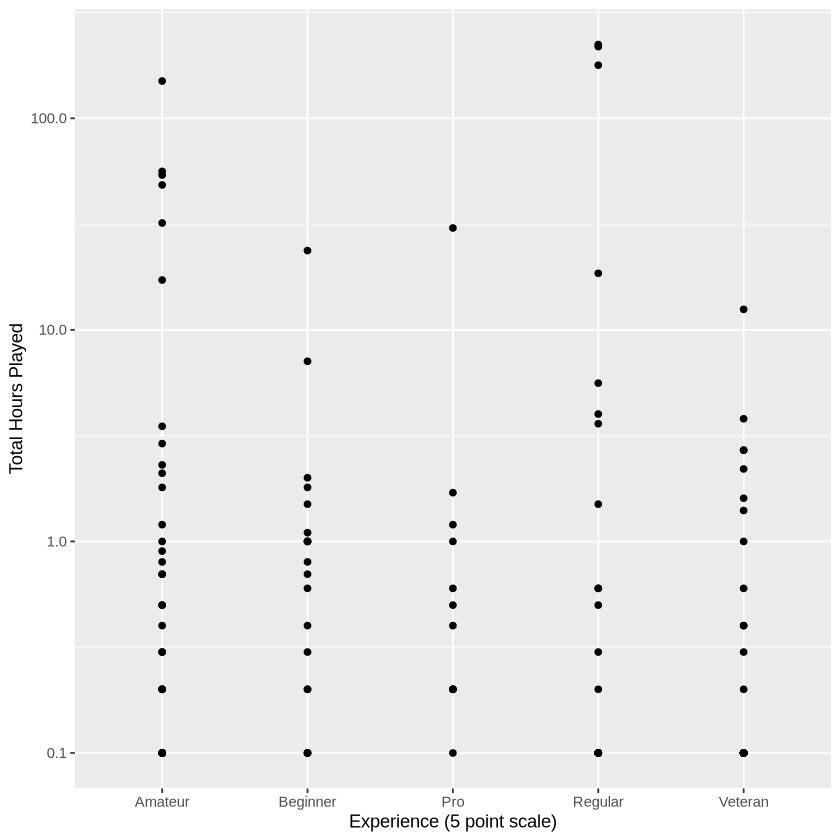

In [12]:
experience_time_plot = players |>
    filter(played_hours > 0) |>
    ggplot(aes(x = experience, y = played_hours)) +
    geom_point() +
    labs(x = "Experience (5 point scale)", y = "Total Hours Played") +
    scale_y_log10()

experience_time_plot

experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Veteran,FALSE,71453e425f07d10da4fa2b349c83e73ccdf0fb3312f778b35c5802c3292c87bd,0.3,Pascal,Male,22
Amateur,FALSE,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Dylan,Prefer not to say,57
Pro,TRUE,d9473710057f7d42f36570f0be83817a4eea614029ff90cf50d8889cdd729d11,0.2,Ahmed,Other,NA


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


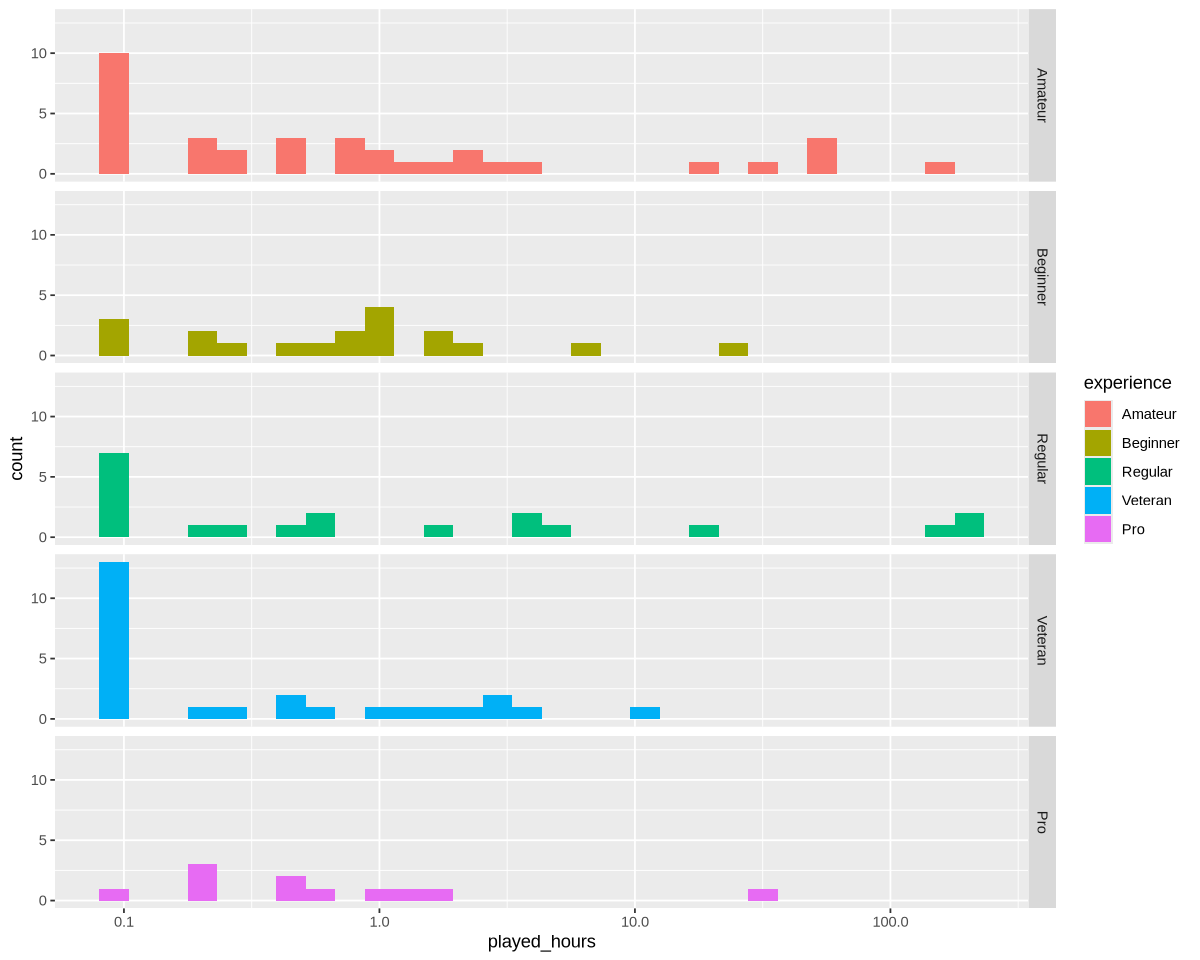

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


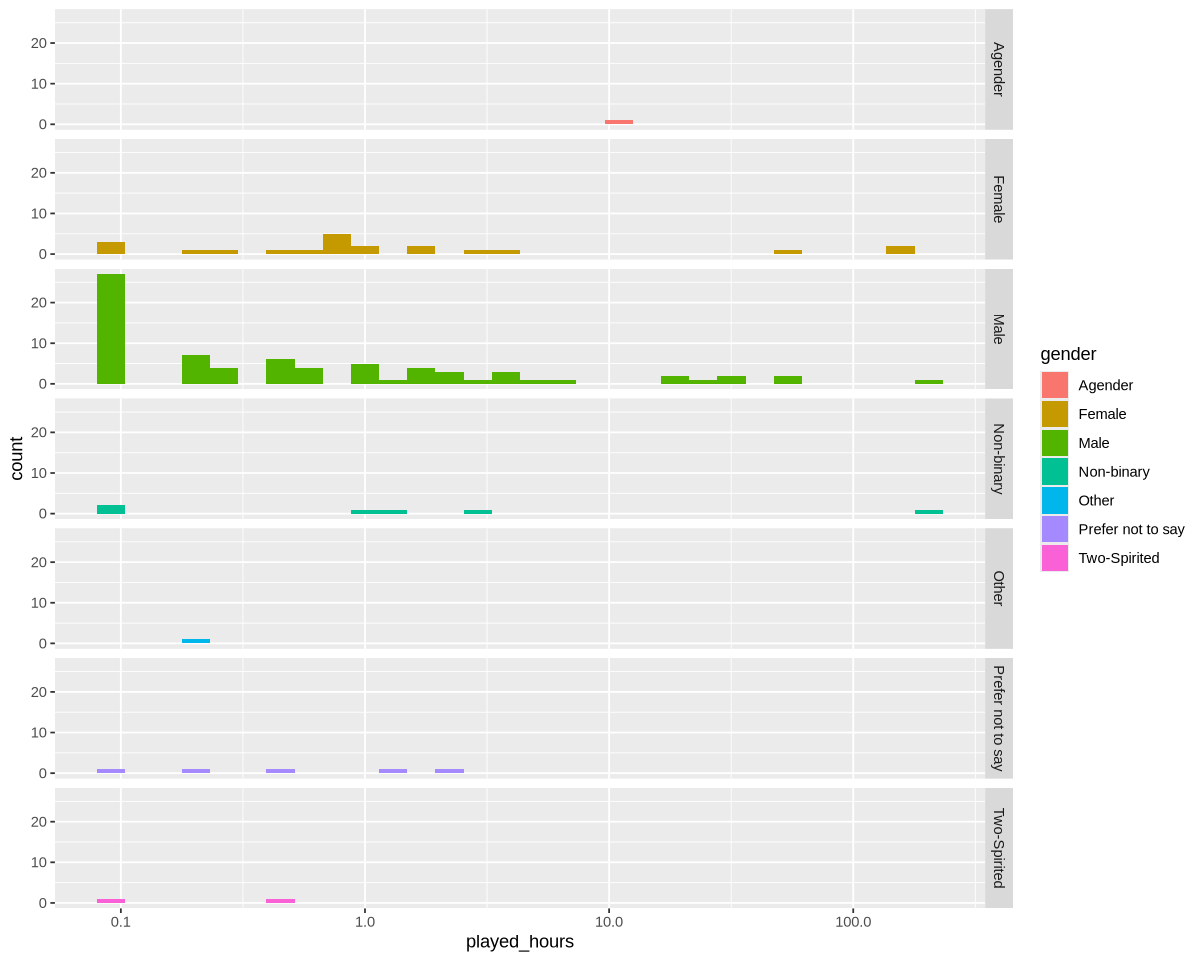

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


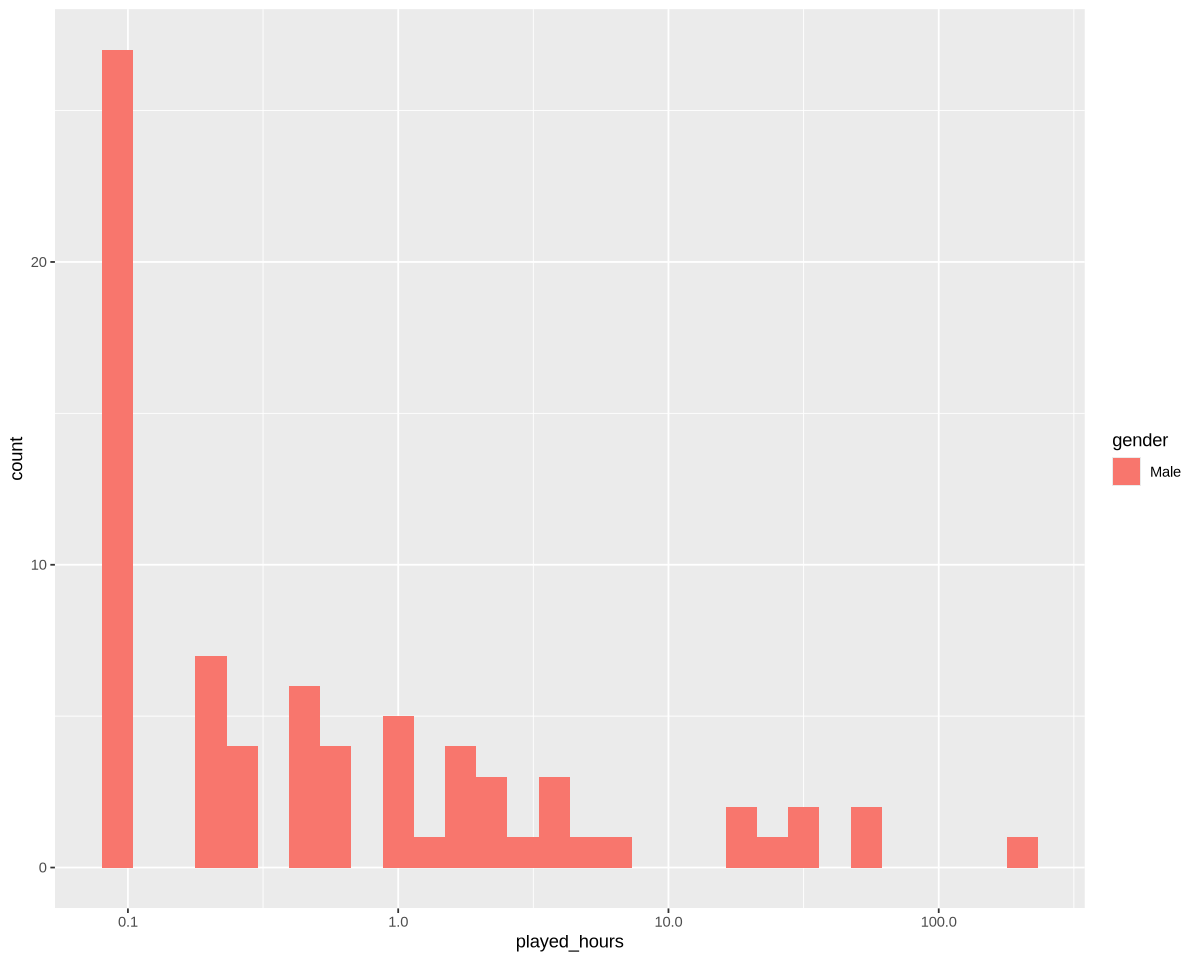

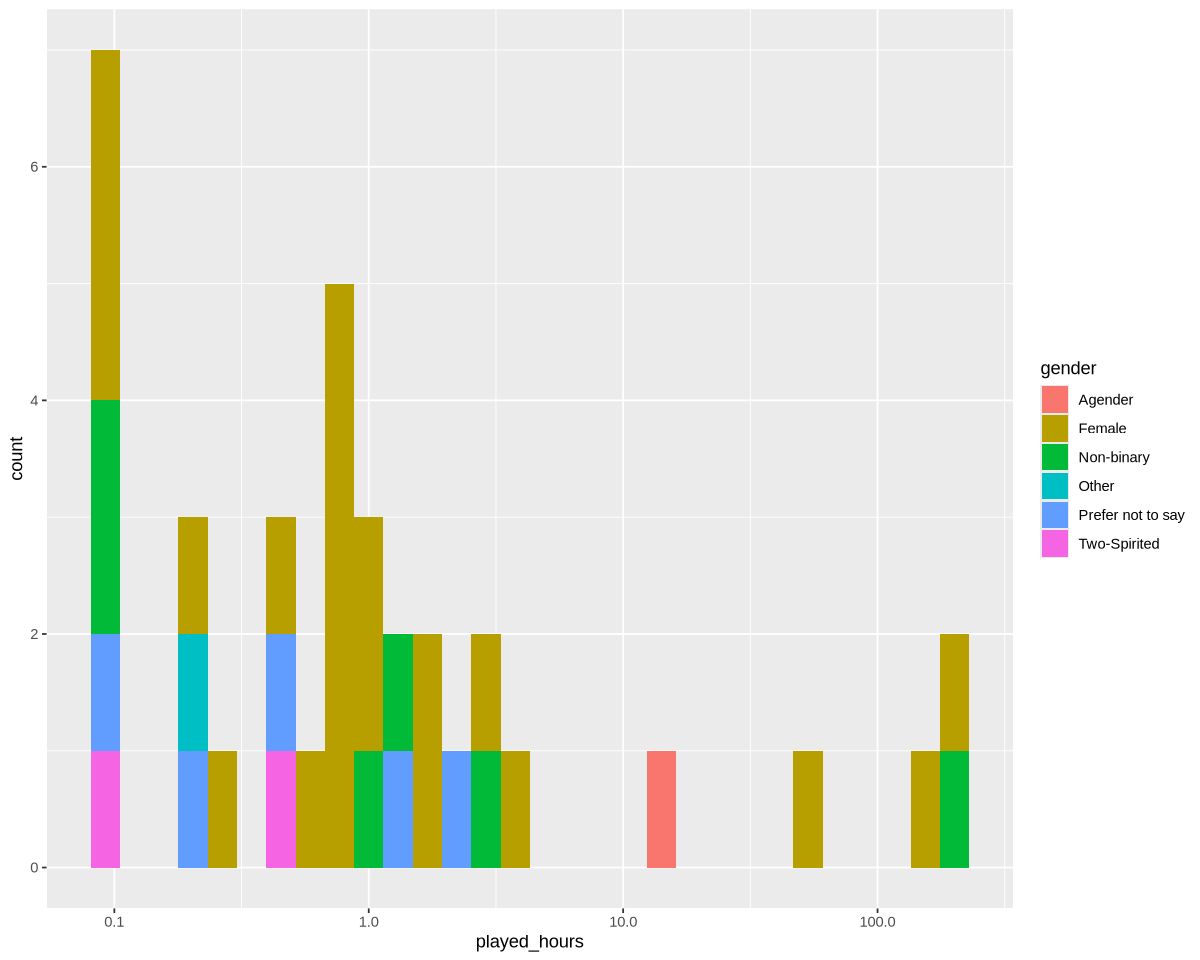

In [57]:
options(repr.plot.height = 8, repr.plot.width = 10)

short_duration_players = players |>
    filter(played_hours < 1)

short_duration_players

players_0_adjusted = players |>
    mutate(played_hours = played_hours + 0.01)

hours_histogram = players |>
    mutate(experience = factor(experience, c("Amateur", "Beginner", "Regular", "Veteran", "Pro"))) |>
    filter(played_hours > 0) |>
    ggplot(aes(x = played_hours, fill = experience)) +
    geom_histogram() +
    scale_x_log10() +
    facet_grid(rows = vars(experience))

hours_histogram

hours_gender_histogram = players |>
    filter(played_hours > 0) |>
    ggplot(aes(x = played_hours, fill = gender)) +
    geom_histogram() +
    scale_x_log10() +
    facet_grid(rows = vars(gender))

hours_gender_histogram

hours_male_histogram = players |>
    filter(played_hours > 0) |>
    filter(gender == "Male") |>
    ggplot(aes(x = played_hours, fill = gender)) +
    geom_histogram() +
    scale_x_log10()

hours_male_histogram

hours_other_genders_histogram = players |>
    filter(played_hours > 0) |>
    filter(gender != "Male") |>
    ggplot(aes(x = played_hours, fill = gender)) +
    geom_histogram() +
    scale_x_log10()

hours_other_genders_histogram

4. Methods and Plan
- Propose one method to address the question of interest using the selected dataset
- Explain why you chose it
- Don't actually do any modelling or presenting of results, this is just the high-level plan and justification

Must include:
- Why is this method appropriate?
- Which assumptions are required, if any, to apply the method selected?
- What are the potential limitations or weaknesses of the method selected?
- How are you going to compare and select the model?
- How are you going to process the data to apply the model? For example: Are you splitting the data? How? How many splits? What proportions will you use for the splits? At what stage will you split? Will there be a validation set? Will you use cross validation?

My plan:
- I'll be doing regression using Age and Experience as the predictor variables and played_hours as the response variable.
- I suspect it should be knn instead of linear, since it's more than one predictor variable, and I wouldn't guess the relationship is linear. But I'll wait to decide until I see the exploratory graphs.
- I'm doing regression because I want to predict a numeric value, it isn't classification. We could hypothetically create buckets like small/medium/large amounts of data and turn this into a classification problem, based on thresholds of played_hours, but that's just layering over what is an underlying numeric value. Keeping it numberic makes it more flexible for the researches to define what threshold they care about.
- I do need the predictor variables to be numeric which is why I can't use gender and why I'll need to convert experience into a numeric scale
- A weakness of this method is that it would become slow if the project does collect much larger quantities of data. A strength is that it will work well if the relationship is non-linear. (Again, if the scatterplot actually looks linear, I'll probably need to swap to linear regression!)

Breaking down the process for doing the regression:
- I'll split the data into training and testing, with a 75/25 split, like we've typically done
- I'll scale and center my predictors, creating a recipe
- I'll create a model where the number of neighbors K is a tuning value
- I'll do a 5-fold cross-validation using vfold_cv, on the training data. This will give me 5 splits of the data that I can use to figure out my best choice of K.
- I'll use a tune_grid to run through the cross-validation for K = 1 to 100. (100 is chosen since there'll be 147 entries in the training data, and then just over 100 after the vfold, so a K of 100 covers all the way to the extreme of counting most other points as neighbours. I expect the best K to be much lower.)
- I'll look at the RMSE from the tune_grid results and pick the K associated with the lowest RMSE
- I'll set up another model that uses this best K value, and fit it to the full training data set.
- Finally I'll run prediction on the testing data set and report the RMSPE to get a sense of how good the model is.

 